In [1]:
from tensorflow.keras import Model

def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.6602 - loss: 0.8167 - val_accuracy: 0.7550 - val_loss: 0.5325
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.8130 - loss: 0.4263 - val_accuracy: 0.9868 - val_loss: 0.1334
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9809 - loss: 0.0964 - val_accuracy: 0.9868 - val_loss: 0.0551
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9949 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 5.9779e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9941 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 6.2483e-05
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 4.5495e-04 - val_accuracy: 1.0000 - val_loss: 1.6868e-05
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9967 - loss: 0.0045 - 

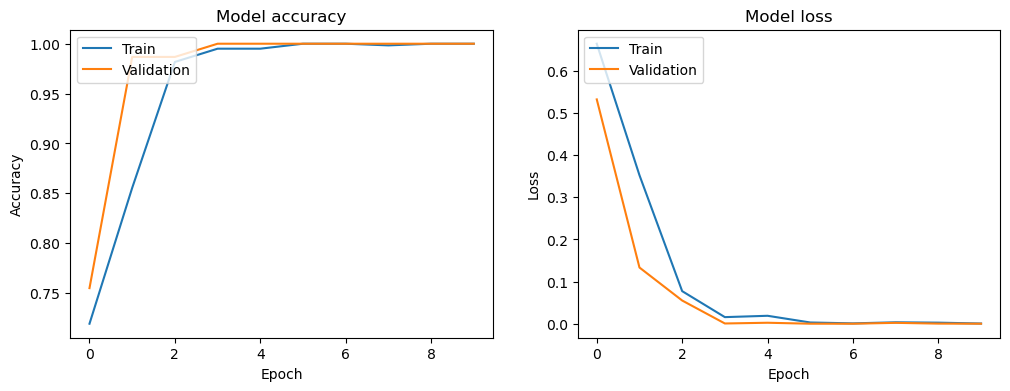

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


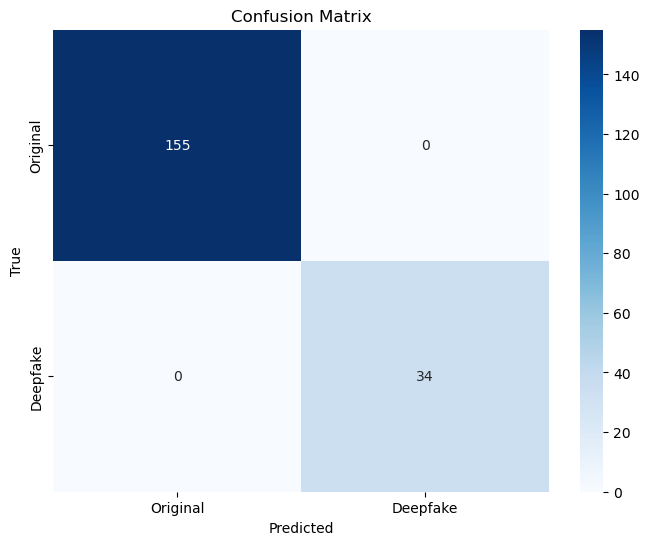

              precision    recall  f1-score   support

    Original       1.00      1.00      1.00       155
    Deepfake       1.00      1.00      1.00        34

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189



ValueError: The layer sequential has never been called and thus has no defined input.

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', name='conv1'),
    MaxPooling2D((2, 2), name='maxpool1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D((2, 2), name='maxpool2'),
    Conv2D(128, (3, 3), activation='relu', name='conv3'),
    MaxPooling2D((2, 2), name='maxpool3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['conv1', 'conv2', 'conv3']  # Specify the layers you want to visualize
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')
ply.show()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.6778 - loss: 0.7988 - val_accuracy: 0.7550 - val_loss: 0.4335
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.8744 - loss: 0.3177 - val_accuracy: 0.9801 - val_loss: 0.0400
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9907 - loss: 0.0459 - val_accuracy: 0.9470 - val_loss: 0.0872
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9925 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 1.0115e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 1.0000 - loss: 2.4902e-04 - val_accuracy: 1.0000 - val_loss: 5.0627e-05
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 1.0000 - loss: 2.5708e-04 - 

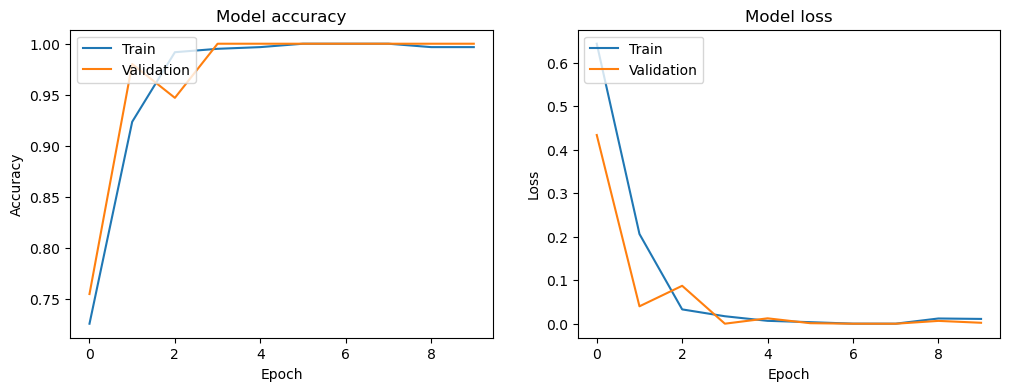

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


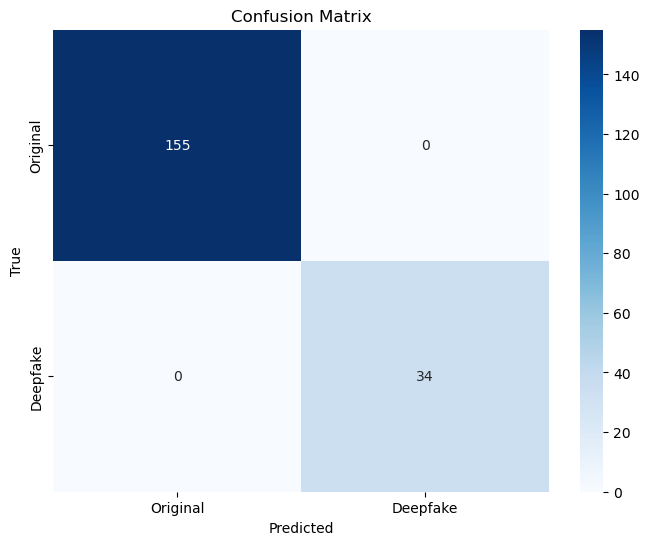

              precision    recall  f1-score   support

    Original       1.00      1.00      1.00       155
    Deepfake       1.00      1.00      1.00        34

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189



ValueError: The layer sequential_1 has never been called and thus has no defined input.

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'


# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', name='conv1'),
    MaxPooling2D((2, 2), name='maxpool1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D((2, 2), name='maxpool2'),
    Conv2D(128, (3, 3), activation='relu', name='conv3'),
    MaxPooling2D((2, 2), name='maxpool3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['conv1', 'conv2', 'conv3']  # Specify the layers you want to visualize
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')

plt.show()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.7293 - loss: 0.7505 - val_accuracy: 0.8675 - val_loss: 0.3219
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9592 - loss: 0.1915 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9959 - loss: 0.0226 - val_accuracy: 0.9934 - val_loss: 0.0090
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9986 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 8.4589e-04
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9984 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 4.0741e-05
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 1.0000 - loss: 2.7610e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9967 - loss: 0.0033 - val_

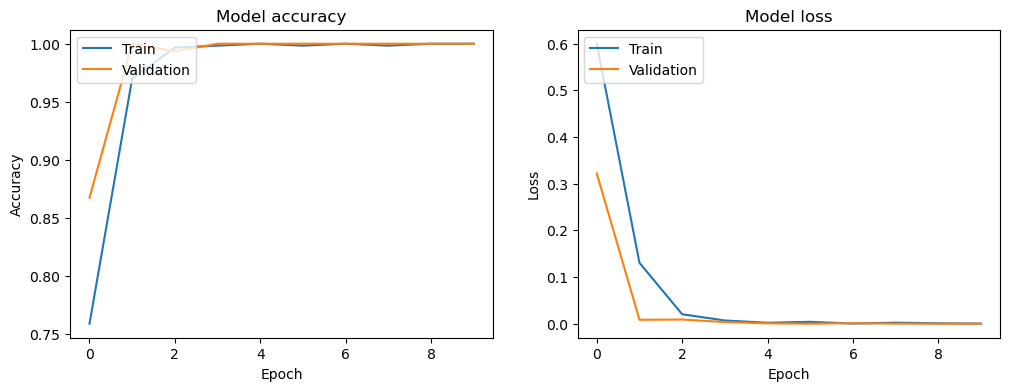

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', name='conv1'),
    MaxPooling2D((2, 2), name='maxpool1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D((2, 2), name='maxpool2'),
    Conv2D(128, (3, 3), activation='relu', name='conv3'),
    MaxPooling2D((2, 2), name='maxpool3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Ensure the model has been called by making a prediction
_ = model.predict(X_test[:1])

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['conv1', 'conv2', 'conv3']  # Specify the layers you want to visualize
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.6881 - loss: 0.6362 - val_accuracy: 0.9801 - val_loss: 0.2966
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9510 - loss: 0.1975 - val_accuracy: 0.9934 - val_loss: 0.0187
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9913 - loss: 0.0274 - val_accuracy: 0.9934 - val_loss: 0.0075
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9979 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9944 - loss: 0.0088 - val_accuracy: 0.9934 - val_loss: 0.0053
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 1.0000 - loss: 3.1360e-04 - val_accuracy: 1.0000 - val_loss: 7.0287e-04
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 1.0000 - loss: 2.5419e-05 - val_

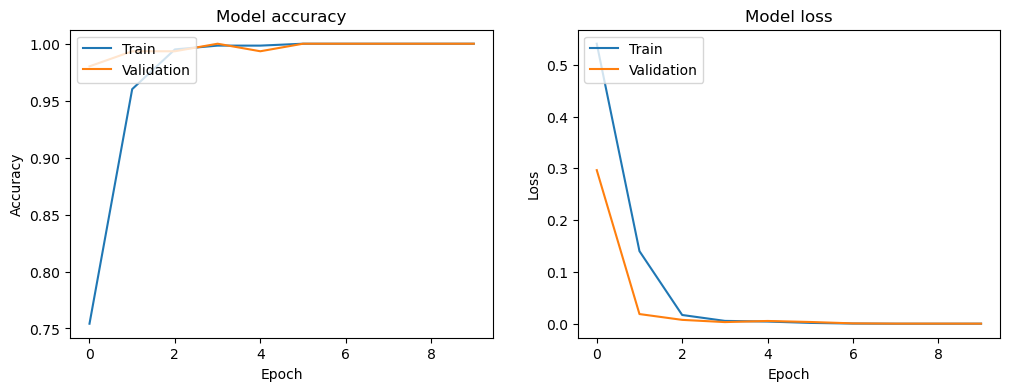

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


ValueError: The layer sequential has never been called and thus has no defined input.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', name='conv1'),
    MaxPooling2D((2, 2), name='maxpool1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D((2, 2), name='maxpool2'),
    Conv2D(128, (3, 3), activation='relu', name='conv3'),
    MaxPooling2D((2, 2), name='maxpool3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Ensure the model has been called by making a prediction
_ = model.predict(X_test[:1])

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['conv1', 'conv2', 'conv3']  # Specify the layers you want to visualize
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

In [1]:
from tensorflow.keras.models import Model

# Function to create an activation model
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]  # Get the outputs of specified layers
    activation_model = Model(inputs=model.input, outputs=outputs)  # Create a new model that will return these outputs
    return activation_model

# Make sure the model has been trained or at least called once before this step
# For instance, using model.predict on some data ensures the model is "called"
_ = model.predict(X_test[:1])  # Running a dummy prediction to initialize the model

# Specify the layers you want to visualize
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']  # Update these with your actual conv layer names

# Create the activation model
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get activations
activations = activation_model.predict(sample_image)

# Plotting the activations
for i, activation in enumerate(activations):
    num_filters = activation.shape[-1]
    size = activation.shape[1]
    plt.figure(figsize=(15, 15))
    plt.suptitle(f"Activations from Layer: {layer_names[i]}")
    
    for j in range(num_filters):
        plt.subplot(8, 8, j + 1)  # Assuming 64 filters, adjust for other numbers
        plt.imshow(activation[0, :, :, j], cmap='viridis')
        plt.axis('off')
    plt.show()


NameError: name 'model' is not defined

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D, Reshape
from sklearn.metrics import confusion_matrix, classification_report

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define AutoEncoder Model
class AutoEncoder(Model):
    def __init__(self, units):
        super(AutoEncoder, self).__init__()
        self.units = units
        self.encoder = Dense(units=self.units, activation='relu')
        self.decoder = Dense(units=128 * 128 * 3, activation='sigmoid')

    def call(self, inputs):
        Z = self.encoder(inputs)
        reconstructed = self.decoder(Z)
        reconstructed = Reshape((128, 128, 3))(reconstructed)
        return reconstructed

# Build and compile the autoencoder
autoencoder = AutoEncoder(units=64)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.build(input_shape=(None, 128 * 128 * 3))

# Flatten images for autoencoder input
X_train_flat = X_train.reshape((-1, 128 * 128 * 3))
X_test_flat = X_test.reshape((-1, 128 * 128 * 3))

# Train the autoencoder
history_ae = autoencoder.fit(X_train_flat, X_train_flat, epochs=10, batch_size=32, validation_split=0.2)

# Plot training & validation loss for autoencoder
plt.figure(figsize=(6, 4))
plt.plot(history_ae.history['loss'], label='Train')
plt.plot(history_ae.history['val_loss'], label='Validation')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get encoded representations of the images
X_train_encoded = autoencoder.encoder(X_train_flat).numpy()
X_test_encoded = autoencoder.encoder(X_test_flat).numpy()

# Define CNN model
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', name='conv1'),
    MaxPooling2D((2, 2), name='maxpool1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D((2, 2), name='maxpool2'),
    Conv2D(128, (3, 3), activation='relu', name='conv3'),
    MaxPooling2D((2, 2), name='maxpool3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Ensure the model has been called by making a prediction
_ = model.predict(X_test[:1])

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['conv1', 'conv2', 'conv3']  # Specify the layers you want to visualize
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


ValueError: Dimensions must be equal, but are 49152 and 3 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, auto_encoder_1/reshape_1/Reshape)' with input shapes: [?,49152], [?,128,128,3].

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7043 - loss: 0.6999 - val_accuracy: 0.7550 - val_loss: 0.4903
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8657 - loss: 0.3318 - val_accuracy: 0.9536 - val_loss: 0.0677
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9836 - loss: 0.0353 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9981 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9995 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 1.0000 - loss: 6.7989e-04 - val_accuracy: 1.0000 - val_loss: 2.2437e-04
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 1.0000 - loss: 3.5713e-04 - val_accuracy: 1.0000 - val_loss: 2.0788e-04
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 1.0000 - loss: 3.3955e-0

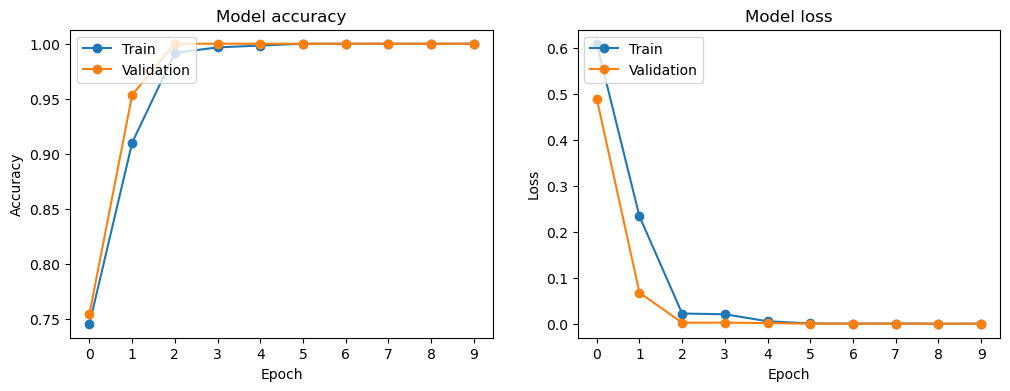

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


ValueError: The layer sequential_1 has never been called and thus has no defined input.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', name='conv1'),
    MaxPooling2D((2, 2), name='maxpool1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D((2, 2), name='maxpool2'),
    Conv2D(128, (3, 3), activation='relu', name='conv3'),
    MaxPooling2D((2, 2), name='maxpool3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['accuracy'])))
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['loss'])))
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Ensure the model has been called by making a prediction
_ = model.predict(X_test[:1])

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['conv1', 'conv2', 'conv3']  # Specify the layers you want to visualize
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
import math

for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    size = activation.shape[1]
    display_grid = np.zeros((size, size * num_channels))
    for i in range(num_channels):
        activation_channel = activation[0, :, :, i]
        activation_channel -= activation_channel.mean()
        activation_channel /= (activation_channel.std() + 1e-5)
        activation_channel *= 64
        activation_channel += 128
        activation_channel = np.clip(activation_channel, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = activation_channel
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(f'Activations of layer {layer_names[layer_index]}')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Original', 'Deepfake'],
            yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 49152)          │     6,340,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,765,248 (56.32 MB)

 Trainable params: 14,765,248 (56.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - loss: 0.1028 - val_loss: 0.0237
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.0218 - val_loss: 0.0163
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0135 - val_loss: 0.0133


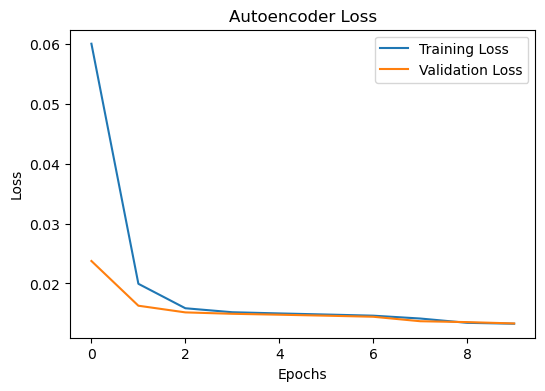

In [11]:
from tensorflow.keras.layers import Reshape

# Define the encoder
encoder_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoder_output = Dense(128, activation='relu')(x)

encoder = Model(encoder_input, encoder_output)

# Define the decoder
decoder_input = Dense(128, activation='relu')(encoder_output)
x = Dense(128 * 128 * 3, activation='sigmoid')(decoder_input)  # Flattened output
decoder_output = Reshape((128, 128, 3))(x)

autoencoder = Model(encoder_input, decoder_output)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
autoencoder.summary()

# Train the autoencoder using the original (non-flattened) images
history_ae = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot training & validation loss for autoencoder
plt.figure(figsize=(6, 4))
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 49152)          │     6,340,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,765,248 (56.32 MB)

 Trainable params: 14,765,248 (56.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 0.0955 - val_loss: 0.0222
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0202 - val_loss: 0.0159
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 0.0129 - val_loss: 0.0130


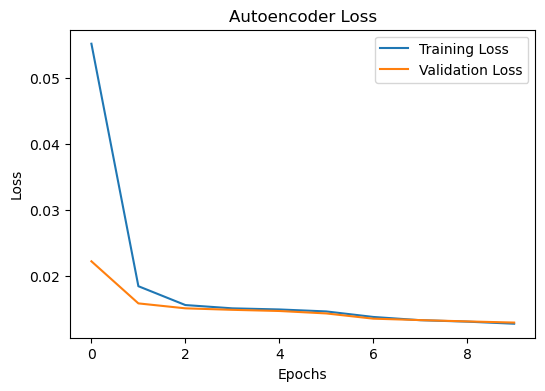

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.7821 - loss: 0.6669 - val_accuracy: 0.7616 - val_loss: 0.3623
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.8719 - loss: 0.3082 - val_accuracy: 0.9801 - val_loss: 0.0774
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9821 - loss: 0.0561 - val_accuracy: 0.9868 - val_loss: 0.0327
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.9972 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 6.3656e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 2.6574e-04
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9976 - loss: 0.0114 - val_accuracy: 0.9934 - val_loss: 0.0094
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 6.9665e-04
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 1.0000 - loss: 5.6280e-04 - 

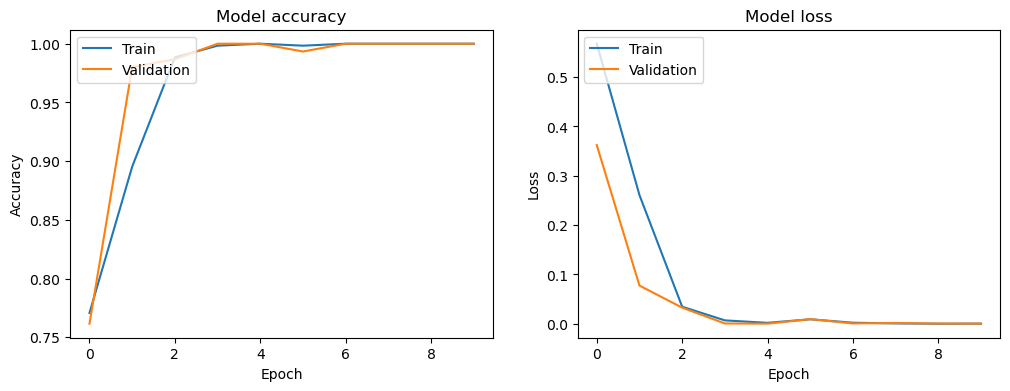

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Reshape
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- AUTOENCODER PART ---

# Define the encoder
encoder_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoder_output = Dense(128, activation='relu')(x)

encoder = Model(encoder_input, encoder_output)

# Define the decoder
decoder_input = Dense(128, activation='relu')(encoder_output)
x = Dense(128 * 128 * 3, activation='sigmoid')(decoder_input)  # Flattened output
decoder_output = Reshape((128, 128, 3))(x)

autoencoder = Model(encoder_input, decoder_output)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
autoencoder.summary()

# Train the autoencoder using the original (non-flattened) images
history_ae = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot training & validation loss for autoencoder
plt.figure(figsize=(6, 4))
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- CNN CLASSIFIER PART ---

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', name='conv1'),
    MaxPooling2D((2, 2), name='maxpool1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2'),
    MaxPooling2D((2, 2), name='maxpool2'),
    Conv2D(128, (3, 3), activation='relu', name='conv3'),
    MaxPooling2D((2, 2), name='maxpool3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history_cnn = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the CNN model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Ensure the model has been called by making a prediction
_ = model.predict(X_test[:1])

# --- VISUALIZATION PART ---

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['conv1', 'conv2', 'conv3']  # Specify the layers you want to visualize
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')

plt.show()

# --- CONFUSION MATRIX & CLASSIFICATION REPORT ---

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import ImageGrid

# --- Dataset Loading ---
class SpectrogramDataset(Dataset):
    def __init__(self, image_folder, label):
        self.images = []
        self.labels = []
        for filename in os.listdir(image_folder):
            if filename.endswith('.png'):
                img_path = os.path.join(image_folder, filename)
                img = plt.imread(img_path)
                img = np.expand_dims(img, axis=0)  # Add channel dimension
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# Paths to spectrogram folders
deepfake_folder = '/path/to/deepfake/folder'
original_folder = '/path/to/original/folder'

# Create datasets
deepfake_dataset = SpectrogramDataset(deepfake_folder, label=1)
original_dataset = SpectrogramDataset(original_folder, label=0)

# Combine datasets
combined_dataset = deepfake_dataset + original_dataset

# Split dataset into training and testing sets
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model_image_classifier = CNNClassifier()

# --- Feature Map Visualization Setup ---
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Add forward hooks to capture activations from specific layers
model_image_classifier.features[0].register_forward_hook(get_activation('features.0.0'))
model_image_classifier.features[3].register_forward_hook(get_activation('features.3.0'))
model_image_classifier.features[6].register_forward_hook(get_activation('features.6.0'))

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_image_classifier.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 10
for epoch in range(epochs):
    model_image_classifier.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_image_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# --- Inference and Visualization of Feature Maps ---
model_image_classifier.eval()

# Get a sample from the test set for visualization
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0)  # Take a single image

with torch.no_grad():
    outputs = model_image_classifier(sample_image)

# Define feature layers to visualize
features_list = ['features.0.0', 'features.3.0', 'features.6.0']

# Visualize the activations for each layer
for layer_name in features_list:
    act = activation[layer_name]
    batch, n_features, height, width = act.size()

    # Display in matplotlib, using multiples of 16 for rounding
    num_cols_per_img = 16
    num_rows_per_img = math.ceil(n_features / num_cols_per_img)

    # Convert the activations to NumPy for plotting
    grid_img_numpy = act[0].cpu().detach().numpy()

    # Create figure and grid
    fig = plt.figure(figsize=(20., 20.))
    fig.suptitle(f"Feature Map: {layer_name}")
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows_per_img, num_cols_per_img), axes_pad=0.1)

    for ax, im in zip(grid, grid_img_numpy):
        ax.imshow(im, cmap='viridis')
        ax.axis('off')

    plt.show()

# --- Evaluate the Model ---
all_preds = []
all_labels = []

for inputs, labels in test_loader:
    with torch.no_grad():
        outputs = model_image_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))


ModuleNotFoundError: No module named 'torch'

In [17]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 10.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import ImageGrid

# --- Dataset Loading ---
class SpectrogramDataset(Dataset):
    def __init__(self, image_folder, label):
        self.images = []
        self.labels = []
        for filename in os.listdir(image_folder):
            if filename.endswith('.png'):
                img_path = os.path.join(image_folder, filename)
                img = plt.imread(img_path)
                img = np.expand_dims(img, axis=0)  # Add channel dimension
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# Paths to spectrogram folders
deepfake_folder = '/path/to/deepfake/folder'
original_folder = '/path/to/original/folder'

# Create datasets
deepfake_dataset = SpectrogramDataset(deepfake_folder, label=1)
original_dataset = SpectrogramDataset(original_folder, label=0)

# Combine datasets
combined_dataset = deepfake_dataset + original_dataset

# Split dataset into training and testing sets
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model_image_classifier = CNNClassifier()

# --- Feature Map Visualization Setup ---
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Add forward hooks to capture activations from specific layers
model_image_classifier.features[0].register_forward_hook(get_activation('features.0.0'))
model_image_classifier.features[3].register_forward_hook(get_activation('features.3.0'))
model_image_classifier.features[6].register_forward_hook(get_activation('features.6.0'))

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_image_classifier.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 10
for epoch in range(epochs):
    model_image_classifier.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_image_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# --- Inference and Visualization of Feature Maps ---
model_image_classifier.eval()

# Get a sample from the test set for visualization
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0)  # Take a single image

with torch.no_grad():
    outputs = model_image_classifier(sample_image)

# Define feature layers to visualize
features_list = ['features.0.0', 'features.3.0', 'features.6.0']

# Visualize the activations for each layer
for layer_name in features_list:
    act = activation[layer_name]
    batch, n_features, height, width = act.size()

    # Display in matplotlib, using multiples of 16 for rounding
    num_cols_per_img = 16
    num_rows_per_img = math.ceil(n_features / num_cols_per_img)

    # Convert the activations to NumPy for plotting
    grid_img_numpy = act[0].cpu().detach().numpy()

    # Create figure and grid
    fig = plt.figure(figsize=(20., 20.))
    fig.suptitle(f"Feature Map: {layer_name}")
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows_per_img, num_cols_per_img), axes_pad=0.1)

    for ax, im in zip(grid, grid_img_numpy):
        ax.imshow(im, cmap='viridis')
        ax.axis('off')

    plt.show()

# --- Evaluate the Model ---
all_preds = []
all_labels = []

for inputs, labels in test_loader:
    with torch.no_grad():
        outputs = model_image_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))


ModuleNotFoundError: No module named 'torchvision'

In [21]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import ImageGrid

# --- Dataset Loading ---
class SpectrogramDataset(Dataset):
    def __init__(self, image_folder, label):
        self.images = []
        self.labels = []
        for filename in os.listdir(image_folder):
            if filename.endswith('.png'):
                img_path = os.path.join(image_folder, filename)
                img = plt.imread(img_path)
                img = np.expand_dims(img, axis=0)  # Add channel dimension
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Create datasets
deepfake_dataset = SpectrogramDataset(deepfake_folder, label=1)
original_dataset = SpectrogramDataset(original_folder, label=0)

# Combine datasets
combined_dataset = deepfake_dataset + original_dataset

# Split dataset into training and testing sets
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model_image_classifier = CNNClassifier()

# --- Feature Map Visualization Setup ---
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Add forward hooks to capture activations from specific layers
model_image_classifier.features[0].register_forward_hook(get_activation('features.0.0'))
model_image_classifier.features[3].register_forward_hook(get_activation('features.3.0'))
model_image_classifier.features[6].register_forward_hook(get_activation('features.6.0'))

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_image_classifier.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 10
for epoch in range(epochs):
    model_image_classifier.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
    # If there's an extra dimension, remove it
        if inputs.dim() == 5:
            inputs = inputs.squeeze(-1)  # Removes the last dimension
        
        optimizer.zero_grad()
        outputs = model_image_classifier(inputs)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# --- Inference and Visualization of Feature Maps ---
model_image_classifier.eval()

# Get a sample from the test set for visualization
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0)  # Take a single image

with torch.no_grad():
    outputs = model_image_classifier(sample_image)

# Define feature layers to visualize
features_list = ['features.0.0', 'features.3.0', 'features.6.0']

# Visualize the activations for each layer
for layer_name in features_list:
    act = activation[layer_name]
    batch, n_features, height, width = act.size()

    # Display in matplotlib, using multiples of 16 for rounding
    num_cols_per_img = 16
    num_rows_per_img = math.ceil(n_features / num_cols_per_img)

    # Convert the activations to NumPy for plotting
    grid_img_numpy = act[0].cpu().detach().numpy()

    # Create figure and grid
    fig = plt.figure(figsize=(20., 20.))
    fig.suptitle(f"Feature Map: {layer_name}")
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows_per_img, num_cols_per_img), axes_pad=0.1)

    for ax, im in zip(grid, grid_img_numpy):
        ax.imshow(im, cmap='viridis')
        ax.axis('off')

    plt.show()

# --- Evaluate the Model ---
all_preds = []
all_labels = []

for inputs, labels in test_loader:
    with torch.no_grad():
        outputs = model_image_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 1, 600, 1000, 4]

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define a simple CNN model for image classification
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 75 * 125, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # Assuming 10 classes for output
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.classifier(x)
        return x

# Define a dummy dataset for illustration
class DummyDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.data = np.random.randn(num_samples, 1, 600, 1000).astype(np.float32)  # Random image data
        self.labels = np.random.randint(0, 10, size=num_samples).astype(np.long)  # Random labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

# Initialize the dataset and dataloader
train_dataset = DummyDataset()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model_image_classifier = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_image_classifier.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Adjust the number of epochs as needed
    model_image_classifier.train()
    for inputs, labels in train_loader:
        if inputs.dim() == 5:
            inputs = inputs.squeeze(-1)  # Remove extra dimension if present

        optimizer.zero_grad()
        try:
            outputs = model_image_classifier(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        except RuntimeError as e:
            print(f"RuntimeError: {e}")
            break

    print(f"Epoch {epoch+1} completed")

print("Training finished.")


/var/folders/tc/p09j7ll56zbbhd266ds5wqh40000gn/T/ipykernel_46767/3663071128.py:37: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.
  self.labels = np.random.randint(0, 10, size=num_samples).astype(np.long)  # Random labels


AttributeError: module 'numpy' has no attribute 'long'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define a simple CNN model for image classification
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 75 * 125, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # Assuming 10 classes for output
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.classifier(x)
        return x

# Define a dummy dataset for illustration
class DummyDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.data = np.random.randn(num_samples, 1, 600, 1000).astype(np.float32)  # Random image data
        self.labels = np.random.randint(0, 10, size=num_samples).astype(np.int64)  # Random labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

# Initialize the dataset and dataloader
train_dataset = DummyDataset()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model_image_classifier = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_image_classifier.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Adjust the number of epochs as needed
    model_image_classifier.train()
    for inputs, labels in train_loader:
        if inputs.dim() == 5:
            inputs = inputs.squeeze(-1)  # Remove extra dimension if present

        optimizer.zero_grad()
        try:
            outputs = model_image_classifier(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        except RuntimeError as e:
            print(f"RuntimeError: {e}")
            break

    print(f"Epoch {epoch+1} completed")

print("Training finished.")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4800000 and 1200000x256)
Epoch 1 completed
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4800000 and 1200000x256)
Epoch 2 completed
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4800000 and 1200000x256)
Epoch 3 completed
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4800000 and 1200000x256)
Epoch 4 completed
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4800000 and 1200000x256)
Epoch 5 completed
Training finished.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define a simple CNN model for image classification
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Calculate the size of the input to the fully connected layer
        def get_output_size(input_size):
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, *input_size)
                output = self.features(dummy_input)
                return output.view(-1).size(0)
        
        input_size = (600, 1000)  # Height x Width of the input images
        fc_input_dim = get_output_size(input_size)
        
        self.classifier = nn.Sequential(
            nn.Linear(fc_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # Assuming 10 classes for output
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.classifier(x)
        return x

# Define a dummy dataset for illustration
class DummyDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.data = np.random.randn(num_samples, 1, 600, 1000).astype(np.float32)  # Random image data
        self.labels = np.random.randint(0, 10, size=num_samples).astype(np.int64)  # Random labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

# Initialize the dataset and dataloader
train_dataset = DummyDataset()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model_image_classifier = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_image_classifier.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Adjust the number of epochs as needed
    model_image_classifier.train()
    for inputs, labels in train_loader:
        if inputs.dim() == 5:
            inputs = inputs.squeeze(-1)  # Remove extra dimension if present

        optimizer.zero_grad()
        try:
            outputs = model_image_classifier(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        except RuntimeError as e:
            print(f"RuntimeError: {e}")
            break

    print(f"Epoch {epoch+1} completed")

print("Training finished.")


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import ImageGrid

# --- Dataset Loading ---
class SpectrogramDataset(Dataset):
    def __init__(self, image_folder, label):
        self.images = []
        self.labels = []
        for filename in os.listdir(image_folder):
            if filename.endswith('.png'):
                img_path = os.path.join(image_folder, filename)
                img = plt.imread(img_path)
                img = np.expand_dims(img, axis=0)  # Add channel dimension
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Create datasets
deepfake_dataset = SpectrogramDataset(deepfake_folder, label=1)
original_dataset = SpectrogramDataset(original_folder, label=0)

# Combine datasets
combined_dataset = deepfake_dataset + original_dataset

# Split dataset into training and testing sets
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Model Definition ---
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model_image_classifier = CNNClassifier()

# --- Feature Map Visualization Setup ---
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Add forward hooks to capture activations from specific layers
model_image_classifier.features[0].register_forward_hook(get_activation('features.0.0'))
model_image_classifier.features[3].register_forward_hook(get_activation('features.3.0'))
model_image_classifier.features[6].register_forward_hook(get_activation('features.6.0'))

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_image_classifier.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 10
for epoch in range(epochs):
    model_image_classifier.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
    # If there's an extra dimension, remove it
        if inputs.dim() == 5:
            inputs = inputs.squeeze(-1)  # Removes the last dimension
        
        optimizer.zero_grad()
        outputs = model_image_classifier(inputs)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# --- Inference and Visualization of Feature Maps ---
model_image_classifier.eval()

# Get a sample from the test set for visualization
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0)  # Take a single image

with torch.no_grad():
    outputs = model_image_classifier(sample_image)

# Define feature layers to visualize
features_list = ['features.0.0', 'features.3.0', 'features.6.0']

# Visualize the activations for each layer
for layer_name in features_list:
    act = activation[layer_name]
    batch, n_features, height, width = act.size()

    # Display in matplotlib, using multiples of 16 for rounding
    num_cols_per_img = 16
    num_rows_per_img = math.ceil(n_features / num_cols_per_img)

    # Convert the activations to NumPy for plotting
    grid_img_numpy = act[0].cpu().detach().numpy()

    # Create figure and grid
    fig = plt.figure(figsize=(20., 20.))
    fig.suptitle(f"Feature Map: {layer_name}")
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows_per_img, num_cols_per_img), axes_pad=0.1)

    for ax, im in zip(grid, grid_img_numpy):
        ax.imshow(im, cmap='viridis')
        ax.axis('off')

    plt.show()

# --- Evaluate the Model ---
all_preds = []
all_labels = []

for inputs, labels in test_loader:
    with torch.no_grad():
        outputs = model_image_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 1, 600, 1000, 4]

In [4]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, model, layer_names):
        super(ActivationLogger, self).__init__()
        self.model = model
        self.layer_names = layer_names
        self.layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
        self.activation_model = tf.keras.models.Model(inputs=model.input, outputs=self.layer_outputs)
        self.activations = []

    def on_epoch_end(self, epoch, logs=None):
        sample_input = self.model.input[0]
        activation_output = self.activation_model.predict([sample_input])
        self.activations.append(activation_output)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Creating an instance of the custom callback
activation_logger = ActivationLogger(model, layer_names)

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, layer_activations in enumerate(activation_logger.activations):
    for j, activation in enumerate(layer_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        activation = np.squeeze(activation)  # Remove batch dimension

        # Plot activation for the first filter
        plt.figure(figsize=(12, 4))
        for k in range(activation.shape[-1]):
            plt.subplot(4, 8, k + 1)
            plt.imshow(activation[..., k], cmap='viridis')
            plt.axis('off')
        plt.show()

AttributeError: property 'model' of 'ActivationLogger' object has no setter

In [8]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_names):
        super(ActivationLogger, self).__init__()
        self.layer_names = layer_names
        self.activations = []
        self.model = None  # Initialize model to None; it will be set later
        
    def set_model(self, model):
        self.model = model
        self.layer_outputs = [layer.output for layer in model.layers if layer.name in self.layer_names]
        self.activation_model = tf.keras.models.Model(inputs=model.input, outputs=self.layer_outputs)
    
    def on_epoch_end(self, epoch, logs=None):
        if not hasattr(self, 'activation_model'):
            return
        sample_input = np.expand_dims(X_train[0], axis=0)  # Using the first sample from the training set
        activation_output = self.activation_model.predict(sample_input)
        self.activations.append(activation_output)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Creating an instance of the custom callback
activation_logger = ActivationLogger(layer_names)

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, epoch_activations in enumerate(activation_logger.activations):
    for j, layer_activation in enumerate(epoch_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        layer_activation = np.squeeze(layer_activation)  # Remove batch dimension

        # Plot activation for the first filter
        plt.figure(figsize=(12, 4))
        for k in range(min(32, layer_activation.shape[-1])):  # Adjust the number of filters to visualize
            plt.subplot(4, 8, k + 1)
            plt.imshow(layer_activation[..., k], cmap='viridis')
            plt.axis('off')
        plt.show()

AttributeError: property 'model' of 'ActivationLogger' object has no setter

In [14]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_names):
        super(ActivationLogger, self).__init__()
        self.layer_names = layer_names
        self.activations = []

    def set_model(self, model):
        self.model = model
        self.layer_outputs = [layer.output for layer in model.layers if layer.name in self.layer_names]
        self.activation_model = tf.keras.models.Model(inputs=model.input, outputs=self.layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        if not hasattr(self, 'activation_model'):
            return
        sample_input = np.expand_dims(X_train[0], axis=0)  # Using the first sample from the training set
        activation_output = self.activation_model.predict(sample_input)
        self.activations.append(activation_output)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Creating an instance of the custom callback
activation_logger = ActivationLogger(layer_names)

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, epoch_activations in enumerate(activation_logger.activations):
    for j, layer_activation in enumerate(epoch_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        layer_activation = np.squeeze(layer_activation)  # Remove batch dimension

        # Plot activation for the first filter
        plt.figure(figsize=(12, 4))
        for k in range(min(32, layer_activation.shape[-1])):  # Adjust the number of filters to visualize
            plt.subplot(4, 8, k + 1)
            plt.imshow(layer_activation[..., k], cmap='viridis')
            plt.axis('off')
        plt.show()

NameError: name 'X_train' is not defined

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_names):
        super(ActivationLogger, self).__init__()
        self.layer_names = layer_names
        self.activations = []

    def set_model(self, model):
        self.model = model
        self.layer_outputs = [layer.output for layer in self.model.layers if layer.name in self.layer_names]
        self.activation_model = tf.keras.models.Model(inputs=self.model.input, outputs=self.layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        if not hasattr(self, 'activation_model'):
            return
        sample_input = np.expand_dims(X_train[0], axis=0)  # Using the first sample from the training set
        activation_output = self.activation_model.predict(sample_input)
        self.activations.append(activation_output)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Creating an instance of the custom callback
activation_logger = ActivationLogger(layer_names)

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, epoch_activations in enumerate(activation_logger.activations):
    for j, layer_activation in enumerate(epoch_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        layer_activation = np.squeeze(layer_activation)  # Remove batch dimension

        # Plot activation for the first filter
        plt.figure(figsize=(12, 4))
        for k in range(min(32, layer_activation.shape[-1])):  # Adjust the number of filters to visualize
            plt.subplot(4, 8, k + 1)
            plt.imshow(layer_activation[..., k], cmap='viridis')
            plt.axis('off')
        plt.show()

AttributeError: property 'model' of 'ActivationLogger' object has no setter

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_names, sample_input):
        super(ActivationLogger, self).__init__()
        self.layer_names = layer_names
        self.activations = []
        self.sample_input = sample_input

    def on_epoch_end(self, epoch, logs=None):
        # Ensure the callback is linked to a model
        layer_outputs = [layer.output for layer in self.model.layers if layer.name in self.layer_names]
        activation_model = tf.keras.models.Model(inputs=self.model.input, outputs=layer_outputs)
        activation_output = activation_model.predict(self.sample_input)
        self.activations.append(activation_output)

# Prepare sample input for activation logging
sample_input = np.expand_dims(X_train[0], axis=0)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Create an instance of the custom callback
activation_logger = ActivationLogger(layer_names, sample_input)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, epoch_activations in enumerate(activation_logger.activations):
    for j, layer_activation in enumerate(epoch_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        layer_activation = np.squeeze(layer_activation)  # Remove batch dimension

        num_filters = min(32, layer_activation.shape[-1])  # Adjust the number of filters to visualize
        fig, axs = plt.subplots(4, 8, figsize=(15, 8))
        for k in range(num_filters):
            ax = axs[k // 8, k % 8]
            ax.imshow(layer_activation[..., k], cmap='viridis')
            ax.axis('off')
        plt.show()

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6406 - loss: 0.7082

ValueError: The layer sequential_7 has never been called and thus has no defined input.

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_names, sample_input):
        super(ActivationLogger, self).__init__()
        self.layer_names = layer_names
        self.activations = []
        self.sample_input = sample_input
        self.activation_model = None  # Initializes later after model is built

    def on_epoch_begin(self, epoch, logs=None):
        if self.activation_model is None:
            layer_outputs = [layer.output for layer in self.model.layers if layer.name in self.layer_names]
            self.activation_model = tf.keras.models.Model(inputs=self.model.input, outputs=layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        activation_output = self.activation_model.predict(self.sample_input)
        self.activations.append(activation_output)

# Prepare sample input for activation logging
sample_input = np.expand_dims(X_train[0], axis=0)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Create an instance of the custom callback
activation_logger = ActivationLogger(layer_names, sample_input)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, epoch_activations in enumerate(activation_logger.activations):
    for j, layer_activation in enumerate(epoch_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        layer_activation = np.squeeze(layer_activation)  # Remove batch dimension

        num_filters = min(32, layer_activation.shape[-1])  # Adjust the number of filters to visualize
        fig, axs = plt.subplots(4, 8, figsize=(15, 8))
        for k in range(num_filters):
            ax = axs[k // 8, k % 8]
            ax.imshow(layer_activation[..., k], cmap='viridis')
            ax.axis('off')
        plt.show()

ValueError: The layer sequential_8 has never been called and thus has no defined input.

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_names, sample_input):
        super(ActivationLogger, self).__init__()
        self.layer_names = layer_names
        self.sample_input = sample_input
        self.activations = []
        self.activation_model = None

    def set_activation_model(self):
        layer_outputs = [layer.output for layer in self.model.layers if layer.name in self.layer_names]
        self.activation_model = tf.keras.models.Model(inputs=self.model.input, outputs=layer_outputs)

    def on_epoch_begin(self, epoch, logs=None):
        if self.activation_model is None:
            self.set_activation_model()

    def on_epoch_end(self, epoch, logs=None):
        if self.activation_model is None:
            self.set_activation_model()
        activation_output = self.activation_model.predict(self.sample_input)
        self.activations.append(activation_output)

# Prepare sample input for activation logging
sample_input = np.expand_dims(X_train[0], axis=0)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Create an instance of the custom callback
activation_logger = ActivationLogger(layer_names, sample_input)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, epoch_activations in enumerate(activation_logger.activations):
    for j, layer_activation in enumerate(epoch_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        layer_activation = np.squeeze(layer_activation)  # Remove batch dimension

        num_filters = min(32, layer_activation.shape[-1])  # Adjust the number of filters to visualize
        fig, axs = plt.subplots(4, 8, figsize=(15, 8))
        for k in range(num_filters):
            ax = axs[k // 8, k % 8]
            ax.imshow(layer_activation[..., k], cmap='viridis')
            ax.axis('off')
        plt.show()

ValueError: The layer sequential_9 has never been called and thus has no defined input.

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom callback to capture activations
class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_names, sample_input):
        super(ActivationLogger, self).__init__()
        self.layer_names = layer_names
        self.sample_input = sample_input
        self.activations = []
        self.activation_model = None

    def on_epoch_begin(self, epoch, logs=None):
        if self.activation_model is None:
            layer_outputs = [layer.output for layer in self.model.layers if layer.name in self.layer_names]
            self.activation_model = tf.keras.models.Model(inputs=self.model.input, outputs=layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        activation_output = self.activation_model.predict(self.sample_input)
        self.activations.append(activation_output)

# Prepare sample input for activation logging
sample_input = np.expand_dims(X_train[0], axis=0)

# Specify the layers for which we want to log activations
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']

# Create an instance of the custom callback
activation_logger = ActivationLogger(layer_names, sample_input)

# Define the CNN model using Input layer
model = Sequential([
    Input(shape=(128, 128, 3), name='input_layer'),
    Conv2D(32, (3, 3), activation='relu', name='conv2d'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_1'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **Make the model process a dummy input to define input shapes**
model.predict(np.expand_dims(X_train[0], axis=0))

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[activation_logger])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Visualize the activations
for i, epoch_activations in enumerate(activation_logger.activations):
    for j, layer_activation in enumerate(epoch_activations):
        print(f"Epoch {i+1} Activation for Layer: {activation_logger.layer_names[j]}")
        layer_activation = np.squeeze(layer_activation)  # Remove batch dimension

        num_filters = min(32, layer_activation.shape[-1])  # Adjust the number of filters to visualize
        fig, axs = plt.subplots(4, 8, figsize=(15, 8))
        for k in range(num_filters):
            ax = axs[k // 8, k % 8]
            ax.imshow(layer_activation[..., k], cmap='viridis')
            ax.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


ValueError: The layer sequential_10 has never been called and thus has no defined input.

ValueError: too many values to unpack (expected 3)

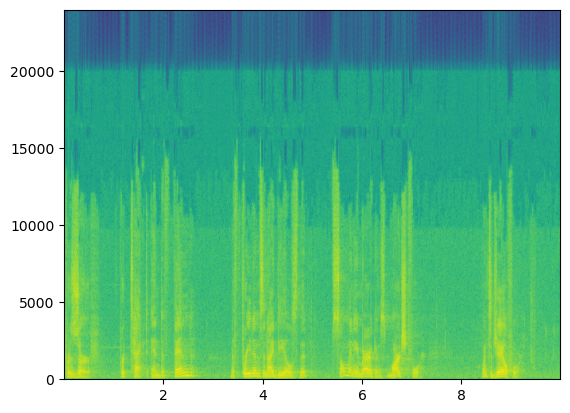

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import cv2

def wav_to_spectrogram(wav_file):
    # Load the .wav file
    sample_rate, data = wavfile.read(wav_file)

    # If stereo, take only one channel
    if len(data.shape) > 1:
        data = data[:, 0]

    # Compute the spectrogram
    frequencies, times, Sxx = plt.specgram(data, NFFT=1024, Fs=sample_rate, noverlap=256)

    # Normalize the spectrogram
    norm = Normalize(vmin=np.min(Sxx), vmax=np.max(Sxx))
    sm = ScalarMappable(cmap='viridis', norm=norm)
    rgb_spectrogram = sm.to_rgba(Sxx)

    # Convert to RGB image
    rgb_image = (rgb_spectrogram[:, :, :3] * 255).astype(np.uint8)

    return rgb_image, sample_rate

def save_rgb_image(rgb_image, output_file):
    # Save the RGB image
    cv2.imwrite(output_file, rgb_image)

def display_rgb_image(rgb_image):
    plt.imshow(rgb_image)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
wav_file = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original/Barack_Obama_1.wav'  # Path to your .wav file
output_file = '/Users/aishwaryadekhane/Desktop/spectrogram_rgb.png'  # Output file name

# Convert wav to RGB spectrogram
rgb_image, sample_rate = wav_to_spectrogram(wav_file)

# Display the RGB spectrogram
display_rgb_image(rgb_image)

# Save the RGB spectrogram image
save_rgb_image(rgb_image, output_file)

print(f'Spectrogram RGB image saved as {output_file}.')
